# Experiment to explore the performance of the different B-VAE models' behaviour over the architecture found in previous experiments

In [44]:
#Now, we prepare the parameters for the different models in dictionaries and dataclasses
from typing import List

import tensorflow as tf
from dataclasses import dataclass, asdict
import numpy as np
from project.infrastructure.images.VAE import VAE
from utils.batches.application.batch_selector import BatchSelector
from utils.epsilons.application.epsilon_generator_selector import EpsilonGeneratorSelector
from utils.external.fid.fid import frechet_inception_distance
from utils.losses.images.application.image_loss_function_selector import ImageLossFunctionSelector


@dataclass(frozen=True)
class Dataset:
    dataset: List
    image_height: int
    image_width: int
    n_channels: int


beta_base = {
    "encoder_architecture": [175, 150, 125, 100, 75, 50, 25],
    "decoder_architecture": [25, 50, 75, 100, 125, 150, 175],
    "encoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "decoder_activations": [tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu,tf.nn.relu],
    "encoder_output_activation": tf.nn.relu,
    "decoder_output_activation": tf.nn.sigmoid,
    "learning_rate": 0.0001,
    "n_distributions": 5,

}
beta2 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA2_MSE.value,
}
beta5 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA5_MSE.value,
}
beta05 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA05_MSE.value,
}
beta02 = {
    **beta_base,
    "loss": ImageLossFunctionSelector.ImageLosses.BETA02_MSE.value,
}

In [21]:
# Common functions

import matplotlib.pyplot as plt


def examples(model, factor = 1.0, cmap = 'gray'):
    generated = model.generate_with_multiple_samples(
        tf.random.normal((9,5)) * factor
    )

    plt.figure()
    fig, axes = plt.subplots(3, 3)
    for i, ax in enumerate(axes.flat):
        image = generated[i]

        ax.imshow(image, cmap=cmap)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def line_plot(y, y_label, x_label, title):
    plt.figure()

    plt.title(title)
    plt.plot(range(1,len(y)+1), y, color='red')

    # Set labels for x and y axes
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

## MNIST dataset

Now we will see how the B-VAE models behave over the MNIST dataset. We will train each model and see how the FID evolves within the training and compare the different models: 2-VAE, 5-VAE, 0.5-VAE and 0.2-VAE

### Preparations

In [102]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.mnist.load_data()
dataset = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=28,
    image_height=28,
    n_channels=1,
)

def create_inception_mnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess MNIST dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 5

intercepted_model = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model.predict(x))

Epoch 1/10
1875/1875 [==============================] - 91s 44ms/step - loss: 0.3228 - accuracy: 0.9018 - val_loss: 0.0593 - val_accuracy: 0.9814
Epoch 2/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1348 - accuracy: 0.9594 - val_loss: 0.0549 - val_accuracy: 0.9824
Epoch 3/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1024 - accuracy: 0.9700 - val_loss: 0.0498 - val_accuracy: 0.9838
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0851 - accuracy: 0.9753 - val_loss: 0.0329 - val_accuracy: 0.9887
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0751 - accuracy: 0.9773 - val_loss: 0.0342 - val_accuracy: 0.9881
Epoch 6/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0641 - accuracy: 0.9808 - val_loss: 0.0312 - val_accuracy: 0.9896
Epoch 7/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0582 - accuracy: 0.9825 - val_loss: 0.0296 -

In [103]:
# We prepare the activations of the dataset

dataset_activations = get_activations(x_test)

313/313 [==============================] - 1s 3ms/step


### Models

In [104]:
MAX_ITER = 500
TIMES = 10

#### 2-VAE

313/313 [==============================] - 2s 7ms/step
LOSS RESULTS OF 2-VAE:



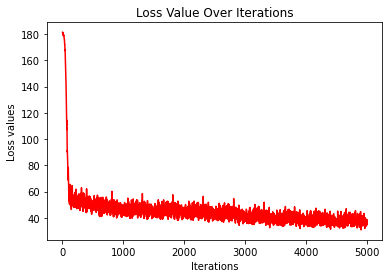

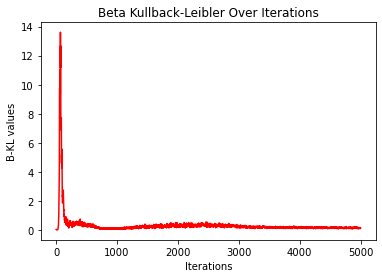

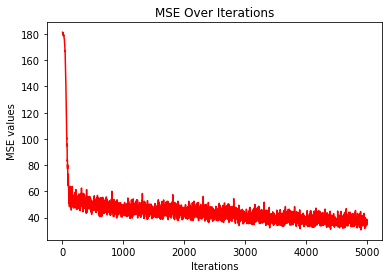


FIDS:



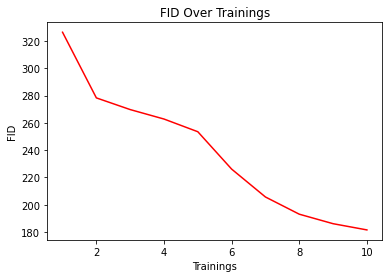

In [105]:
_2VAE = VAE(
    **{**beta2, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_2vae = []
loss_2vae = []
summary_2vae = []
for t in range(1, TIMES+1):
    loss, summary = _2VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _2VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_2vae.append(frechet_inception_distance_metric)
    loss_2vae=loss_2vae+loss
    summary_2vae=summary_2vae+summary

print(f"LOSS RESULTS OF 2-VAE:\n")
line_plot(loss_2vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_2vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_2vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_2vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 5-VAE

313/313 [==============================] - 2s 7ms/step
LOSS RESULTS OF 5-VAE:



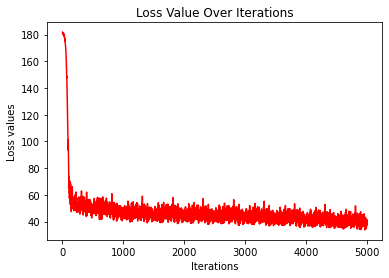

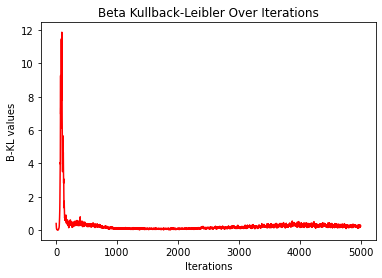

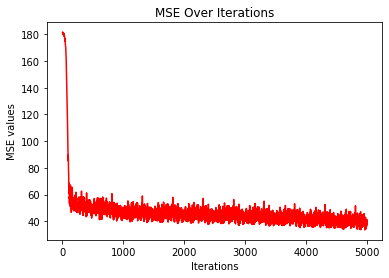


FIDS:



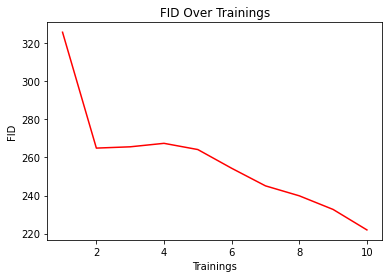

In [106]:
_5VAE = VAE(
    **{**beta5, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_5vae = []
loss_5vae = []
summary_5vae = []
for t in range(1, TIMES+1):
    loss, summary = _5VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _5VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_5vae.append(frechet_inception_distance_metric)
    loss_5vae=loss_5vae+loss
    summary_5vae=summary_5vae+summary

print(f"LOSS RESULTS OF 5-VAE:\n")
line_plot(loss_5vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_5vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_5vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_5vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 0.5-VAE

313/313 [==============================] - 2s 7ms/step
LOSS RESULTS OF 0.5-VAE:



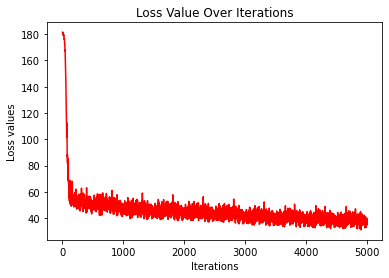

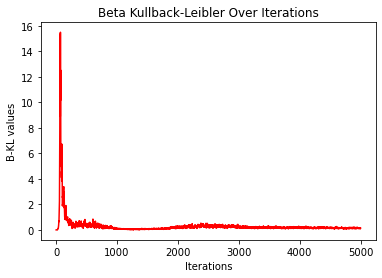

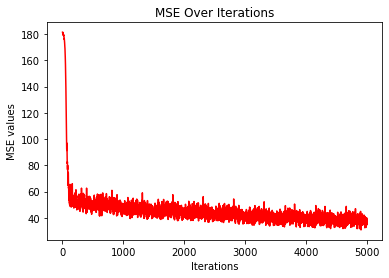


FIDS:



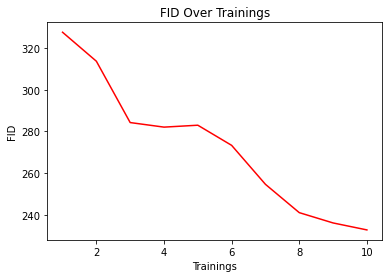

In [107]:
_05VAE = VAE(
    **{**beta05, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_05vae = []
loss_05vae = []
summary_05vae = []
for t in range(1, TIMES+1):
    loss, summary = _05VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _05VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_05vae.append(frechet_inception_distance_metric)
    loss_05vae=loss_05vae+loss
    summary_05vae=summary_05vae+summary

print(f"LOSS RESULTS OF 0.5-VAE:\n")
line_plot(loss_05vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_05vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_05vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_05vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 0.2-VAE

313/313 [==============================] - 2s 7ms/step
LOSS RESULTS OF 0.2-VAE:



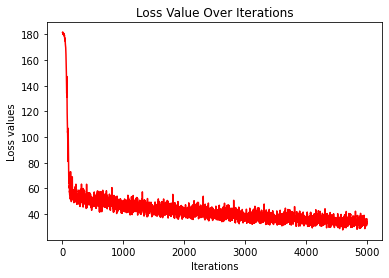

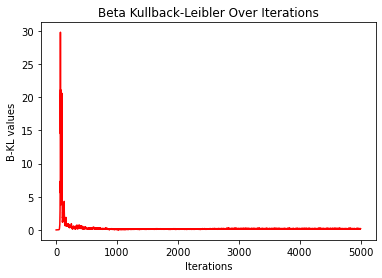

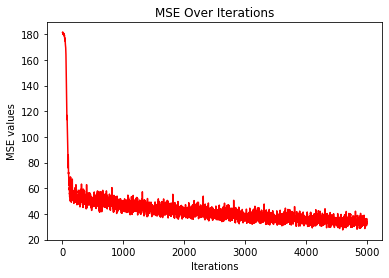


FIDS:



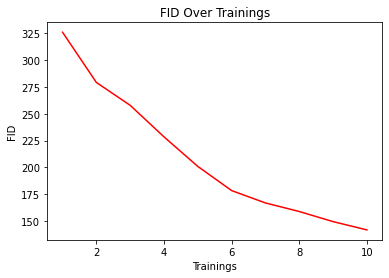

In [108]:
_02VAE = VAE(
    **{**beta02, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_02vae = []
loss_02vae = []
summary_02vae = []
for t in range(1, TIMES+1):
    loss, summary = _02VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _02VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_02vae.append(frechet_inception_distance_metric)
    loss_02vae=loss_02vae+loss
    summary_02vae=summary_02vae+summary

print(f"LOSS RESULTS OF 0.2-VAE:\n")
line_plot(loss_02vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_02vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_02vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_02vae, 'FID', 'Trainings', 'FID Over Trainings')


#### Comparisons

THE MODEL WITH THE LOWEST FID IS:
0.2-VAE==========>141.7185639162904

THE MODEL WITH THE LOWEST LOSS IS:
0.2-VAE==========>33.92837142944336

THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:
0.5-VAE==========>0.14687025547027588

THE MODEL WITH THE LOWEST MSE LOSS IS:
0.2-VAE==========>33.747581481933594

2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

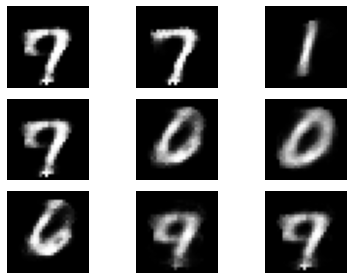

2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

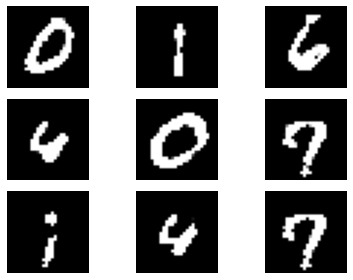

5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

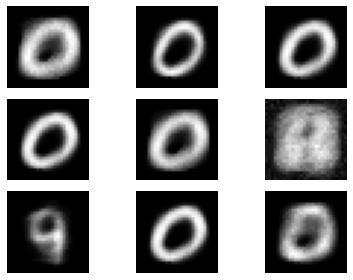

5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

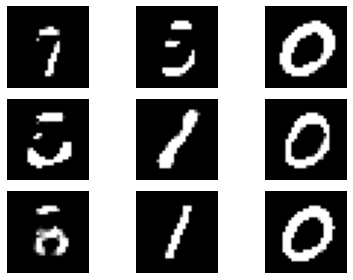

0.5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

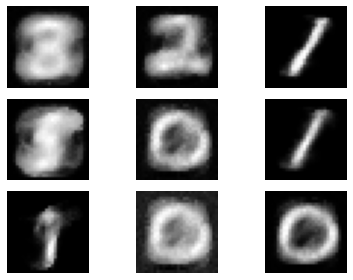

0.5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

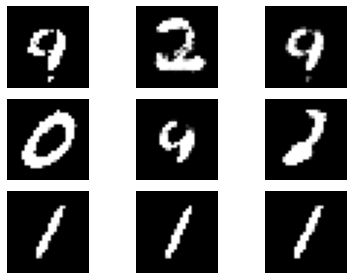

0.2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

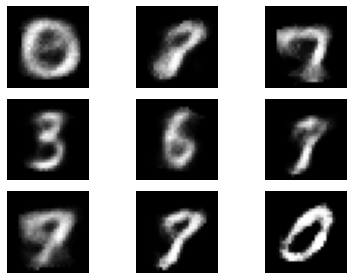

0.2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

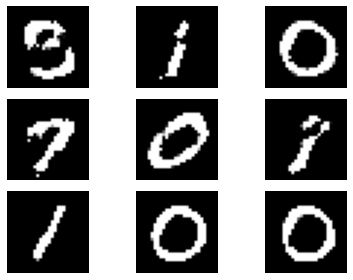

In [109]:
MAPPING = ["2-VAE", "5-VAE", "0.5-VAE", "0.2-VAE"]
FIDS = [fids_2vae[-1], fids_5vae[-1],fids_05vae[-1],fids_02vae[-1]]
LOSSES = [loss_2vae[-1], loss_5vae[-1], loss_05vae[-1], loss_02vae[-1]]
_SUMMARIES = [summary_2vae[-1], summary_5vae[-1], summary_05vae[-1], summary_02vae[-1]]
BDKL_SUMMARIES = list(map(lambda x: x["beta-dkl"], _SUMMARIES))
MSE_SUMMARIES = list(map(lambda x: x["mse"], _SUMMARIES))

print("THE MODEL WITH THE LOWEST FID IS:")
print(f"{MAPPING[FIDS.index(min(FIDS))]}==========>{min(FIDS)}\n")

print("THE MODEL WITH THE LOWEST LOSS IS:")
print(f"{MAPPING[LOSSES.index(min(LOSSES))]}==========>{min(LOSSES)}\n")

print("THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:")
print(f"{MAPPING[BDKL_SUMMARIES.index(min(BDKL_SUMMARIES))]}==========>{min(BDKL_SUMMARIES)}\n")

print("THE MODEL WITH THE LOWEST MSE LOSS IS:")
print(f"{MAPPING[MSE_SUMMARIES.index(min(MSE_SUMMARIES))]}==========>{min(MSE_SUMMARIES)}\n")

print("2-VAE SAMPLING EXAMPLE")
examples(_2VAE)
print("2-VAE SAMPLING EXAMPLE: X100")
examples(_2VAE, factor=100)
print("5-VAE SAMPLING EXAMPLE")
examples(_5VAE)
print("5-VAE SAMPLING EXAMPLE: X100")
examples(_5VAE, factor=100)
print("0.5-VAE SAMPLING EXAMPLE")
examples(_05VAE)
print("0.5-VAE SAMPLING EXAMPLE: X100")
examples(_05VAE, factor=100)
print("0.2-VAE SAMPLING EXAMPLE")
examples(_02VAE)
print("0.2-VAE SAMPLING EXAMPLE: X100")
examples(_02VAE, factor=100)

## FASHION-MNIST dataset

Now we will see how the B-VAE models behave over the MNIST dataset. We will train each model and see how the FID evolves within the training and compare the different models: 2-VAE, 5-VAE, 0.5-VAE and 0.2-VAE

### Preparations

In [110]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.fashion_mnist.load_data()
dataset = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=28,
    image_height=28,
    n_channels=1,
)

def create_inception_fashionmnist_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess dataset
x_train = TRAIN_IMAGES.reshape((-1, 28,28,1))
x_test = TEST_IMAGES.reshape((-1, 28,28,1))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_fashionmnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 5

intercepted_model = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model.predict(x))

Epoch 1/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.6797 - accuracy: 0.7533 - val_loss: 0.4397 - val_accuracy: 0.8415
Epoch 2/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.4792 - accuracy: 0.8256 - val_loss: 0.3889 - val_accuracy: 0.8549
Epoch 3/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.4160 - accuracy: 0.8495 - val_loss: 0.3340 - val_accuracy: 0.8789
Epoch 4/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3856 - accuracy: 0.8612 - val_loss: 0.3124 - val_accuracy: 0.8856
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3589 - accuracy: 0.8729 - val_loss: 0.3089 - val_accuracy: 0.8901
Epoch 6/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3387 - accuracy: 0.8775 - val_loss: 0.3257 - val_accuracy: 0.8809
Epoch 7/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.3246 - accuracy: 0.8827 - val_loss: 0.2965 -

In [111]:
# We prepare the activations of the dataset

dataset_activations = get_activations(x_test)

313/313 [==============================] - 1s 4ms/step


### Models

In [50]:
MAX_ITER = 500
TIMES = 10

#### 2-VAE

313/313 [==============================] - 1s 4ms/step
LOSS RESULTS OF 2-VAE:



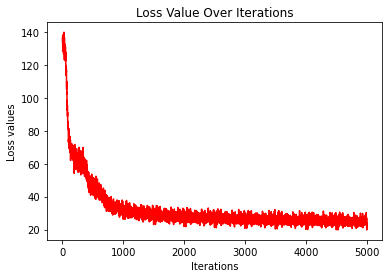

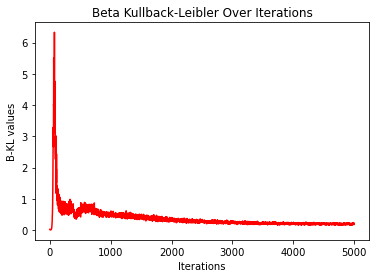

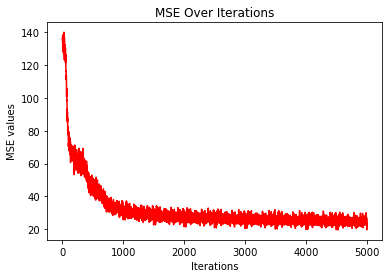


FIDS:



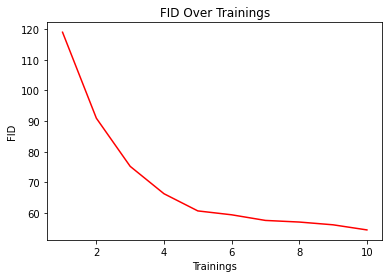

In [112]:
_2VAE = VAE(
    **{**beta2, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_2vae = []
loss_2vae = []
summary_2vae = []
for t in range(1, TIMES+1):
    loss, summary = _2VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _2VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_2vae.append(frechet_inception_distance_metric)
    loss_2vae=loss_2vae+loss
    summary_2vae=summary_2vae+summary

print(f"LOSS RESULTS OF 2-VAE:\n")
line_plot(loss_2vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_2vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_2vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_2vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 5-VAE

313/313 [==============================] - 2s 5ms/step
LOSS RESULTS OF 5-VAE:



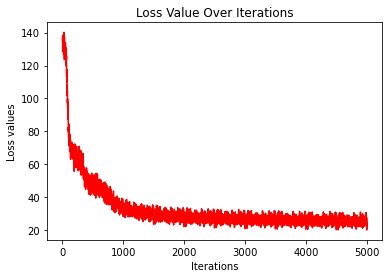

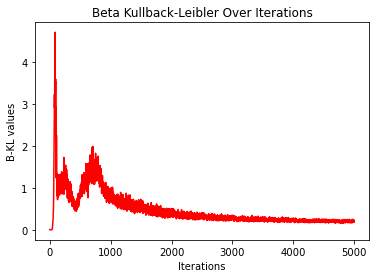

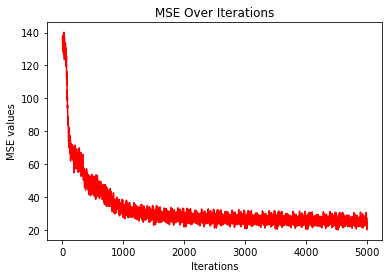


FIDS:



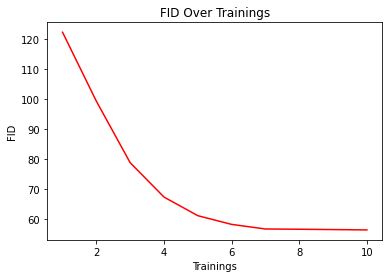

In [113]:
_5VAE = VAE(
    **{**beta5, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_5vae = []
loss_5vae = []
summary_5vae = []
for t in range(1, TIMES+1):
    loss, summary = _5VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _5VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_5vae.append(frechet_inception_distance_metric)
    loss_5vae=loss_5vae+loss
    summary_5vae=summary_5vae+summary

print(f"LOSS RESULTS OF 5-VAE:\n")
line_plot(loss_5vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_5vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_5vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_5vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 0.5-VAE

313/313 [==============================] - 1s 5ms/step
LOSS RESULTS OF 0.5-VAE:



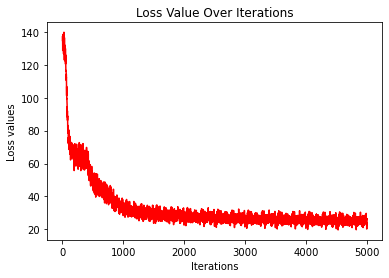

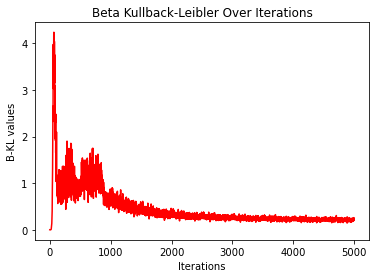

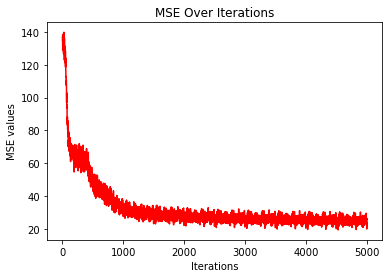


FIDS:



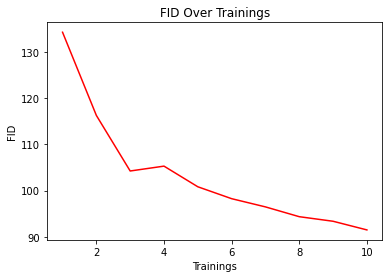

In [114]:
_05VAE = VAE(
    **{**beta05, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_05vae = []
loss_05vae = []
summary_05vae = []
for t in range(1, TIMES+1):
    loss, summary = _05VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _05VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_05vae.append(frechet_inception_distance_metric)
    loss_05vae=loss_05vae+loss
    summary_05vae=summary_05vae+summary

print(f"LOSS RESULTS OF 0.5-VAE:\n")
line_plot(loss_05vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_05vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_05vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_05vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 0.2-VAE

313/313 [==============================] - 1s 4ms/step
LOSS RESULTS OF 0.2-VAE:



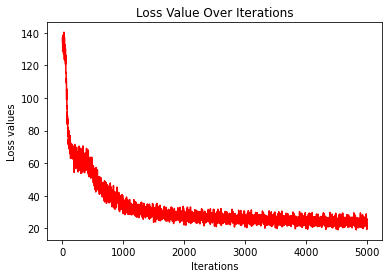

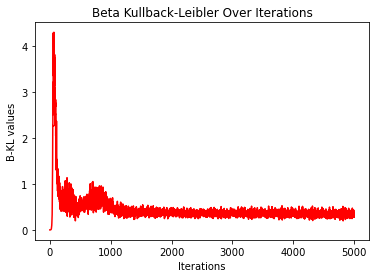

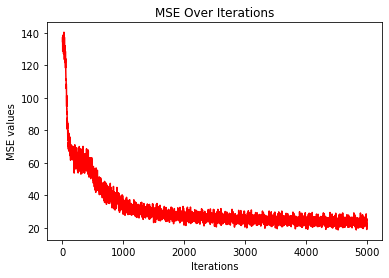


FIDS:



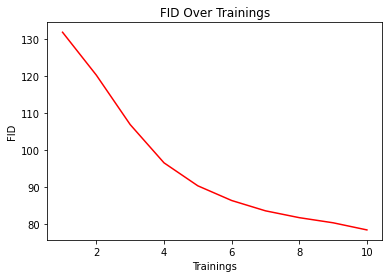

In [115]:
_02VAE = VAE(
    **{**beta02, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_02vae = []
loss_02vae = []
summary_02vae = []
for t in range(1, TIMES+1):
    loss, summary = _02VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _02VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_02vae.append(frechet_inception_distance_metric)
    loss_02vae=loss_02vae+loss
    summary_02vae=summary_02vae+summary

print(f"LOSS RESULTS OF 0.2-VAE:\n")
line_plot(loss_02vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_02vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_02vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_02vae, 'FID', 'Trainings', 'FID Over Trainings')

#### Comparisons

THE MODEL WITH THE LOWEST FID IS:
2-VAE==========>54.518077853535516

THE MODEL WITH THE LOWEST LOSS IS:
0.2-VAE==========>21.826839447021484

THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:
5-VAE==========>0.20405560731887817

THE MODEL WITH THE LOWEST MSE LOSS IS:
0.2-VAE==========>21.551719665527344

2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

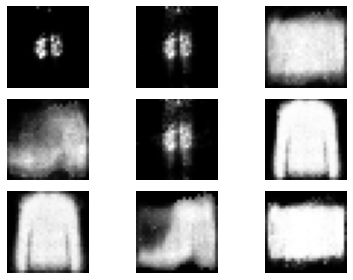

2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

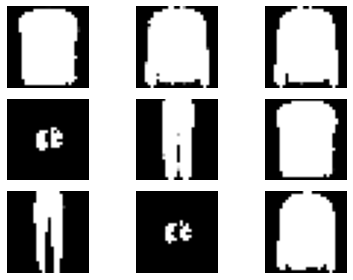

5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

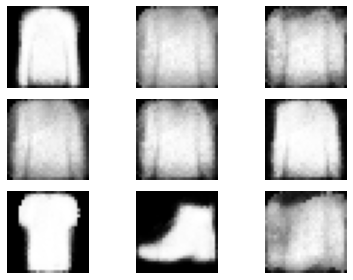

5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

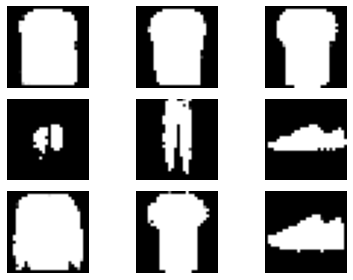

0.5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

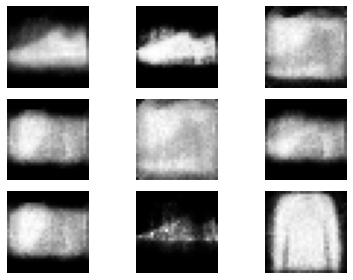

0.5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

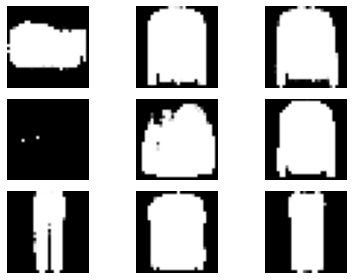

0.2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

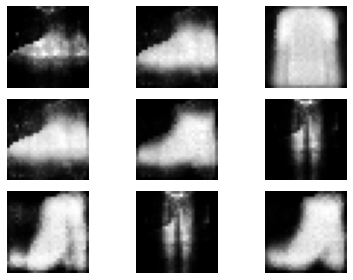

0.2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

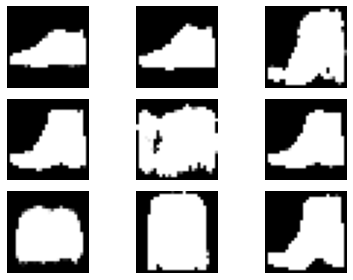

In [117]:
MAPPING = ["2-VAE", "5-VAE", "0.5-VAE", "0.2-VAE"]
FIDS = [fids_2vae[-1], fids_5vae[-1],fids_05vae[-1],fids_02vae[-1]]
LOSSES = [loss_2vae[-1], loss_5vae[-1], loss_05vae[-1], loss_02vae[-1]]
_SUMMARIES = [summary_2vae[-1], summary_5vae[-1], summary_05vae[-1], summary_02vae[-1]]
BDKL_SUMMARIES = list(map(lambda x: x["beta-dkl"], _SUMMARIES))
MSE_SUMMARIES = list(map(lambda x: x["mse"], _SUMMARIES))

print("THE MODEL WITH THE LOWEST FID IS:")
print(f"{MAPPING[FIDS.index(min(FIDS))]}==========>{min(FIDS)}\n")

print("THE MODEL WITH THE LOWEST LOSS IS:")
print(f"{MAPPING[LOSSES.index(min(LOSSES))]}==========>{min(LOSSES)}\n")

print("THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:")
print(f"{MAPPING[BDKL_SUMMARIES.index(min(BDKL_SUMMARIES))]}==========>{min(BDKL_SUMMARIES)}\n")

print("THE MODEL WITH THE LOWEST MSE LOSS IS:")
print(f"{MAPPING[MSE_SUMMARIES.index(min(MSE_SUMMARIES))]}==========>{min(MSE_SUMMARIES)}\n")

print("2-VAE SAMPLING EXAMPLE")
examples(_2VAE)
print("2-VAE SAMPLING EXAMPLE: X100")
examples(_2VAE, factor=100)
print("5-VAE SAMPLING EXAMPLE")
examples(_5VAE)
print("5-VAE SAMPLING EXAMPLE: X100")
examples(_5VAE, factor=100)
print("0.5-VAE SAMPLING EXAMPLE")
examples(_05VAE)
print("0.5-VAE SAMPLING EXAMPLE: X100")
examples(_05VAE, factor=100)
print("0.2-VAE SAMPLING EXAMPLE")
examples(_02VAE)
print("0.2-VAE SAMPLING EXAMPLE: X100")
examples(_02VAE, factor=100)

## CIFAR-10 dataset

Now we will see how the B-VAE models behave over the CIFAR-10 dataset. We will train each model and see how the FID evolves within the training and compare the different models: 2-VAE, 5-VAE, 0.5-VAE and 0.2-VAE

### Preparations

In [82]:
# We prepare the custom inception model for measuring the FID and the dataset

(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.cifar10.load_data()
dataset = Dataset(
    dataset=TRAIN_IMAGES,
    image_width=32,
    image_height=32,
    n_channels=3,
)

def create_inception_cifar10_model():
    tmp_model = tf.keras.Sequential()

    # First Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
    tmp_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional block
    tmp_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    tmp_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    tmp_model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    tmp_model.add(tf.keras.layers.Dense(256, activation='relu'))
    tmp_model.add(tf.keras.layers.Dense(64, activation='relu'))
    tmp_model.add(tf.keras.layers.Dropout(0.5))
    tmp_model.add(tf.keras.layers.Dense(10, activation='softmax'))

    return tmp_model

tf.keras.backend.clear_session()

# Preprocess dataset
x_train = TRAIN_IMAGES.reshape((-1, 32,32,3))
x_test = TEST_IMAGES.reshape((-1, 32,32,3))
x_train = tf.cast(x_train, dtype=tf.float32) / 255.0
x_test = tf.cast(x_test, dtype=tf.float32) / 255.0
y_train = tf.keras.utils.to_categorical(TRAIN_LABELS, num_classes=10)
y_test = tf.keras.utils.to_categorical(TEST_LABELS, num_classes=10)

model = create_inception_cifar10_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

INTERCEPTED_LAYER_INDEX = 8

intercepted_model = tf.keras.Model(inputs=model.input, outputs=model.layers[INTERCEPTED_LAYER_INDEX].output)

def get_activations(x : tf.Tensor) -> tf.Tensor:
    return tf.convert_to_tensor(intercepted_model.predict(x))

Epoch 1/10
1563/1563 [==============================] - 145s 91ms/step - loss: 1.6465 - accuracy: 0.3950 - val_loss: 1.2678 - val_accuracy: 0.5379
Epoch 2/10
1563/1563 [==============================] - 149s 96ms/step - loss: 1.2294 - accuracy: 0.5719 - val_loss: 1.0523 - val_accuracy: 0.6247
Epoch 3/10
1563/1563 [==============================] - 211s 135ms/step - loss: 1.0466 - accuracy: 0.6425 - val_loss: 0.9574 - val_accuracy: 0.6644
Epoch 4/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.9170 - accuracy: 0.6892 - val_loss: 0.8519 - val_accuracy: 0.7056
Epoch 5/10
1563/1563 [==============================] - 203s 130ms/step - loss: 0.8035 - accuracy: 0.7269 - val_loss: 0.8663 - val_accuracy: 0.7084
Epoch 6/10
1563/1563 [==============================] - 208s 133ms/step - loss: 0.7243 - accuracy: 0.7556 - val_loss: 0.8112 - val_accuracy: 0.7296
Epoch 7/10
1563/1563 [==============================] - 211s 135ms/step - loss: 0.6497 - accuracy: 0.7802 - val_lo

In [83]:
# We prepare the activations of the dataset

dataset_activations = get_activations(x_test)

313/313 [==============================] - 6s 19ms/step


### Models

In [85]:
MAX_ITER = 500
TIMES = 10

#### 2-VAE

313/313 [==============================] - 7s 22ms/step
LOSS RESULTS OF 2-VAE:



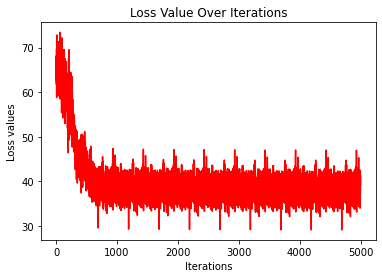

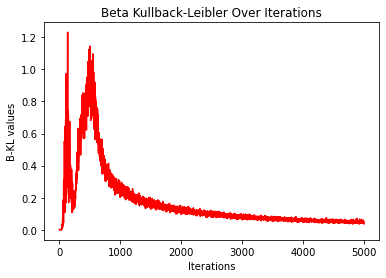

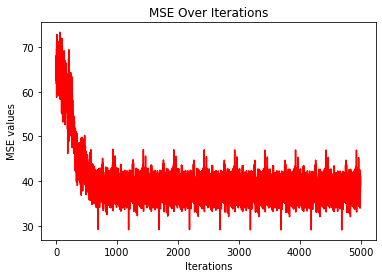


FIDS:



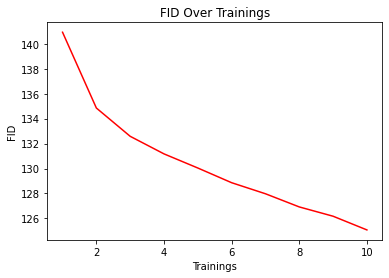

In [86]:
_2VAE = VAE(
    **{**beta2, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_2vae = []
loss_2vae = []
summary_2vae = []
for t in range(1, TIMES+1):
    loss, summary = _2VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _2VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_2vae.append(frechet_inception_distance_metric)
    loss_2vae=loss_2vae+loss
    summary_2vae=summary_2vae+summary

print(f"LOSS RESULTS OF 2-VAE:\n")
line_plot(loss_2vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_2vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_2vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_2vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 5-VAE

313/313 [==============================] - 7s 21ms/step
LOSS RESULTS OF 5-VAE:



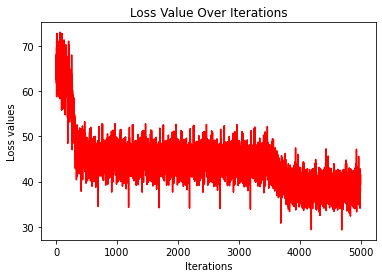

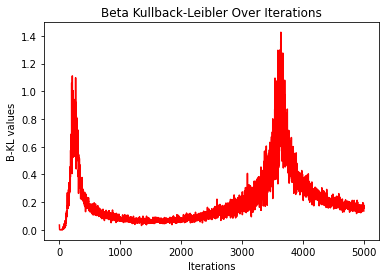

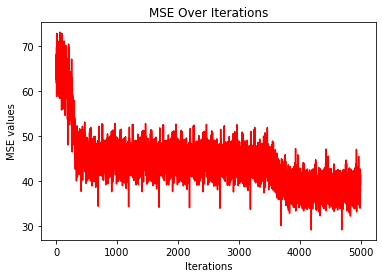


FIDS:



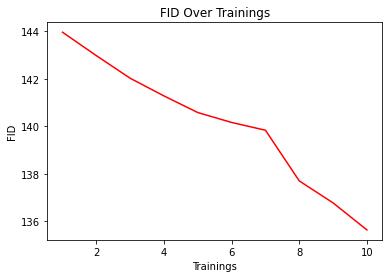

In [87]:
_5VAE = VAE(
    **{**beta5, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_5vae = []
loss_5vae = []
summary_5vae = []
for t in range(1, TIMES+1):
    loss, summary = _5VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _5VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_5vae.append(frechet_inception_distance_metric)
    loss_5vae=loss_5vae+loss
    summary_5vae=summary_5vae+summary

print(f"LOSS RESULTS OF 5-VAE:\n")
line_plot(loss_5vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_5vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_5vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_5vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 0.5-VAE

313/313 [==============================] - 6s 19ms/step
LOSS RESULTS OF 0.5-VAE:



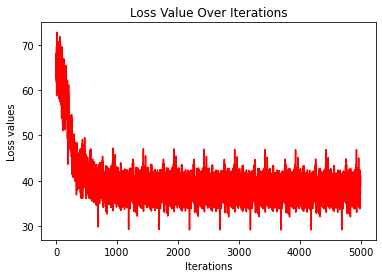

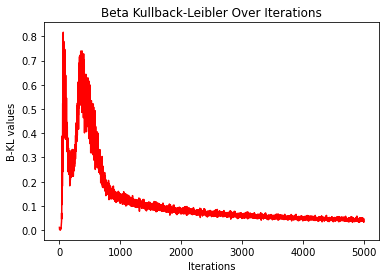

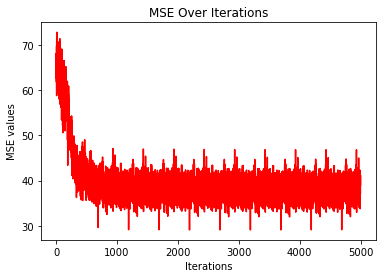


FIDS:



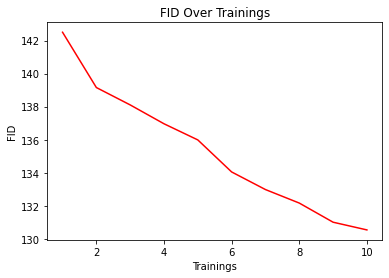

In [88]:
_05VAE = VAE(
    **{**beta05, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_05vae = []
loss_05vae = []
summary_05vae = []
for t in range(1, TIMES+1):
    loss, summary = _05VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _05VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_05vae.append(frechet_inception_distance_metric)
    loss_05vae=loss_05vae+loss
    summary_05vae=summary_05vae+summary

print(f"LOSS RESULTS OF 0.5-VAE:\n")
line_plot(loss_05vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_05vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_05vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_05vae, 'FID', 'Trainings', 'FID Over Trainings')


#### 0.2-VAE

313/313 [==============================] - 6s 20ms/step
LOSS RESULTS OF 0.2-VAE:



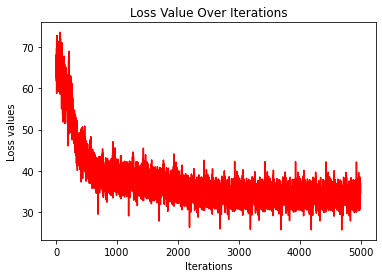

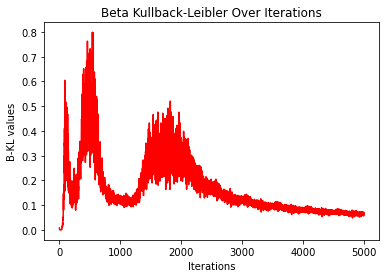

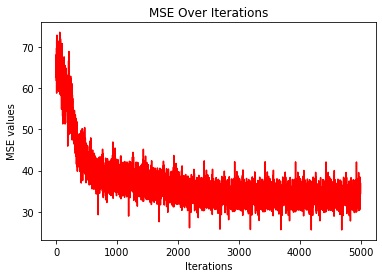


FIDS:



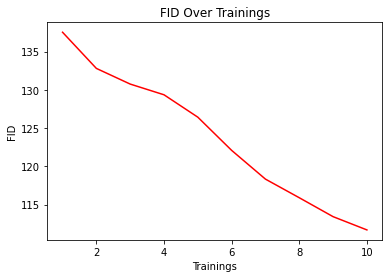

In [90]:
_02VAE = VAE(
    **{**beta02, **asdict(dataset)},
    max_iter=MAX_ITER,
)

fids_02vae = []
loss_02vae = []
summary_02vae = []
for t in range(1, TIMES+1):
    loss, summary = _02VAE.fit_dataset(
        return_loss=True,
        epsilon_generator=EpsilonGeneratorSelector.EpsilonGenerators.SAME_EPSILON.value,
        batch_size=64,
        batch_type=BatchSelector.Batches.CYCLIC_BATCH.value,
        generate_samples=False,
    )

    # we select random images from the dataset
    generated_images = _02VAE.generate_with_random_sample(x_test.shape[0])
    generated_activations = get_activations(generated_images)

    try:
        frechet_inception_distance_metric = frechet_inception_distance(
            dataset_activations,
            generated_activations
        )
    except Exception:
        frechet_inception_distance_metric = np.inf

    fids_02vae.append(frechet_inception_distance_metric)
    loss_02vae=loss_02vae+loss
    summary_02vae=summary_02vae+summary

print(f"LOSS RESULTS OF 0.2-VAE:\n")
line_plot(loss_02vae, 'Loss values', 'Iterations', 'Loss Value Over Iterations')
line_plot(list(map(lambda x: x["beta-dkl"],summary_02vae)), 'B-KL values', 'Iterations', 'Beta Kullback-Leibler Over Iterations')
line_plot(list(map(lambda x: x["mse"],summary_02vae)), 'MSE values', 'Iterations', 'MSE Over Iterations')
print("")
print("FIDS:\n")
line_plot(fids_02vae, 'FID', 'Trainings', 'FID Over Trainings')


#### Comparisons

THE MODEL WITH THE LOWEST FID IS:
0.2-VAE==========>111.681979797075

THE MODEL WITH THE LOWEST LOSS IS:
0.2-VAE==========>34.51534652709961

THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:
0.5-VAE==========>0.04595503211021423

THE MODEL WITH THE LOWEST MSE LOSS IS:
0.2-VAE==========>34.44512176513672

2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

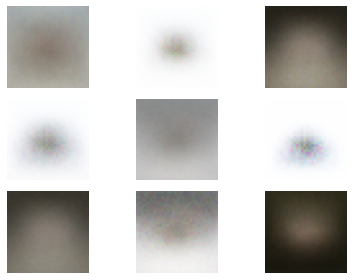

2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

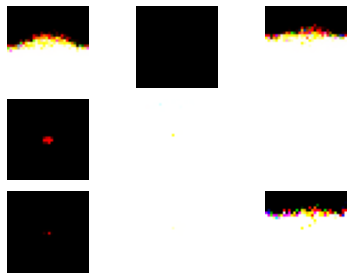

5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

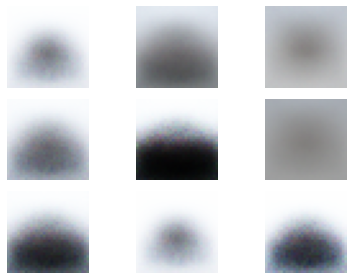

5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

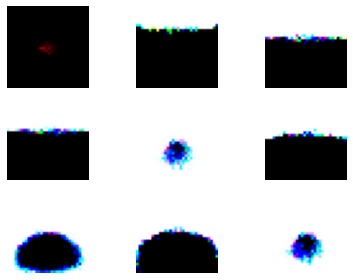

0.5-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

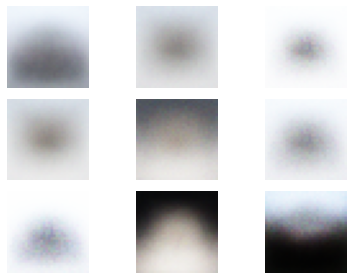

0.5-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

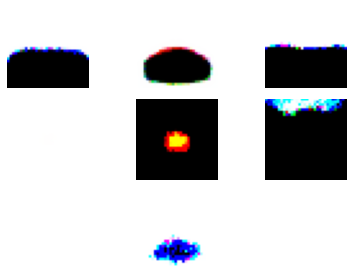

0.2-VAE SAMPLING EXAMPLE


<Figure size 432x288 with 0 Axes>

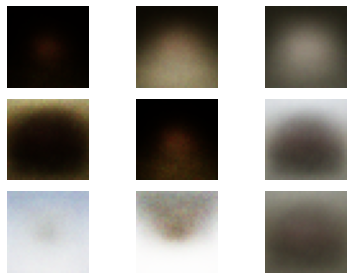

0.2-VAE SAMPLING EXAMPLE: X100


<Figure size 432x288 with 0 Axes>

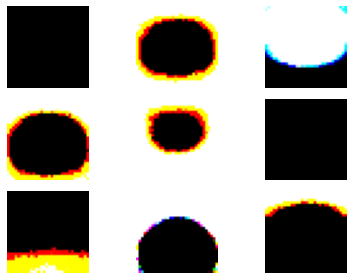

In [101]:
MAPPING = ["2-VAE", "5-VAE", "0.5-VAE", "0.2-VAE"]
FIDS = [fids_2vae[-1], fids_5vae[-1],fids_05vae[-1],fids_02vae[-1]]
LOSSES = [loss_2vae[-1], loss_5vae[-1], loss_05vae[-1], loss_02vae[-1]]
_SUMMARIES = [summary_2vae[-1], summary_5vae[-1], summary_05vae[-1], summary_02vae[-1]]
BDKL_SUMMARIES = list(map(lambda x: x["beta-dkl"], _SUMMARIES))
MSE_SUMMARIES = list(map(lambda x: x["mse"], _SUMMARIES))

print("THE MODEL WITH THE LOWEST FID IS:")
print(f"{MAPPING[FIDS.index(min(FIDS))]}==========>{min(FIDS)}\n")

print("THE MODEL WITH THE LOWEST LOSS IS:")
print(f"{MAPPING[LOSSES.index(min(LOSSES))]}==========>{min(LOSSES)}\n")

print("THE MODEL WITH THE LOWEST KULLBACK-LEIBLER LOSS IS:")
print(f"{MAPPING[BDKL_SUMMARIES.index(min(BDKL_SUMMARIES))]}==========>{min(BDKL_SUMMARIES)}\n")

print("THE MODEL WITH THE LOWEST MSE LOSS IS:")
print(f"{MAPPING[MSE_SUMMARIES.index(min(MSE_SUMMARIES))]}==========>{min(MSE_SUMMARIES)}\n")

print("2-VAE SAMPLING EXAMPLE")
examples(_2VAE, cmap=None)
print("2-VAE SAMPLING EXAMPLE: X100")
examples(_2VAE, factor=100, cmap=None)
print("5-VAE SAMPLING EXAMPLE")
examples(_5VAE, cmap=None)
print("5-VAE SAMPLING EXAMPLE: X100")
examples(_5VAE, factor=100, cmap=None)
print("0.5-VAE SAMPLING EXAMPLE")
examples(_05VAE, cmap=None)
print("0.5-VAE SAMPLING EXAMPLE: X100")
examples(_05VAE, factor=100, cmap=None)
print("0.2-VAE SAMPLING EXAMPLE")
examples(_02VAE, cmap=None)
print("0.2-VAE SAMPLING EXAMPLE: X100")
examples(_02VAE, factor=100, cmap=None)